In [ ]:
!pip install datasets scikit-learn accelerate
!pip install --upgrade transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 39.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 72.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 65.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
# prompt: Import necesary dependencies and load a dataset from drive
import pandas as pd
from sklearn.model_selection import train_test_split
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
import numpy as np
from sklearn.metrics import accuracy_score, f1_score

## Loading data from base

In [3]:
df1 = pd.read_csv('/content/drive/MyDrive/MiSongGiny/data/Task1/subtask1_train.csv', encoding='utf-8')

In [4]:
df1_clean = df1[['id', 'lyrics', 'label']]

In [5]:
df1.head()

,id,lyrics,label
0,T1_TRAIN_0001,"\n[Letra de ""No Me Enseñaste""]\n\n[Verso 1]\nL...",NM
1,T1_TRAIN_0002,"\nPachin!\n\nViajera, te vas de puerta en puer...",M
2,T1_TRAIN_0003,"n\nTe amare toda la vida\nTodos los años, los ...",NM
3,T1_TRAIN_0004,"[Letra de ""Mi lado Oscuro"" ft. Hijo Pródigo]\n...",M
4,T1_TRAIN_0005,"ba-baby\nMuah, jajaja\n[Letra de ""Me Enamore D...",M


In [6]:
#Number of instances for label
df1_clean['label'].value_counts()

,count
label,
NM,1462
M,642


## Loading data from GVL

In [7]:
# Assuming your dataset is in a CSV file named 'your_dataset.csv' in your Google Drive's 'My Drive' folder
df2 = pd.read_csv('/content/drive/MyDrive/MiSongGiny/data/Task1/GVLyrics_Corpus_Spanish.csv', sep=';', encoding='utf-8')

In [8]:
# prompt: Convert Column name Label (0: No gender-based violence in lyrics; 1: Gender-based violence in lyrics) to Label
df2 = df2.rename(columns={'Label (0: No gender-based violence in lyrics; 1: Gender-based violence in lyrics)': 'Label'})

In [9]:
df2_clean = df2.copy()
df2_clean['id'] = ['DF2_' + str(i) for i in range(len(df2_clean))]
df2_clean.rename(columns={'Lyrics': 'lyrics', 'Label': 'label'}, inplace=True)
df2_clean = df2_clean[['id', 'lyrics', 'label']]
#Convert label to M or NM
df2_clean['label'] = df2_clean['label'].map({0: 'NM', 1: 'M'})

In [10]:
df2_clean['label'].value_counts()

,count
label,
NM,778
M,222


In [11]:
df2_clean.head()

,id,lyrics,label
0,DF2_0,\n\nLe bajé las estrellas de un solo golpe\nTa...,NM
1,DF2_1,\n\nDime que aún me queda una esperanza\nDime ...,NM
2,DF2_2,"\n\nDe un tiempo acá, no todo va muy bien\nYa ...",NM
3,DF2_3,\n\nTengo ganas de acostarme con la fe de tu m...,NM
4,DF2_4,"\n\nFjate bien, ¿que no te das cuenta?\nQue ll...",NM


## Loading data from sexism_in_lyrics

In [12]:
df3_text = pd.read_csv('/content/drive/MyDrive/MiSongGiny/data/Task1/sexism_in_lyrics/complete_dataset_paragraphs.csv', encoding='utf-8')

In [13]:
# DF3: Crear ID, renombrar columna de texto y generar label unificado
df3_clean = df3_text.copy()
df3_clean['id'] = ['DF3_' + str(i) for i in range(len(df3_clean))]
df3_clean.rename(columns={'paragraph': 'lyrics'}, inplace=True)

# Crear un label combinado (ejemplo: 'non-sexist', 'sexist', etc.)
def combine_labels(row):
    if row['label_sexist'] == 1.0 :
        return 'M'
    else:
        return 'NM'

df3_clean['label'] = df3_clean.apply(combine_labels, axis=1)
df3_clean = df3_clean[['id', 'lyrics', 'label']]

In [14]:
df3_clean.head()

,id,lyrics,label
0,DF3_0,"Dale, miénteme\nHaz lo que tú quiera' conmigo\...",M
1,DF3_1,"Dalе, miénteme\nHaz lo que tú quiеra' conmigo\...",M
2,DF3_2,"'Toy má' clara que el agua\nBaby, fluyo aunque...",M
3,DF3_3,"Porfa\nTINI, TINI, TINI\nLa Nena de Argentina\...",M
4,DF3_4,"¿Qué importa?\nSi la vida es una sola, ¿qué im...",M


In [15]:
# prompt: Count difrent languages in df3_text

df3_clean['label'].value_counts()


,count
label,
NM,15836
M,4758


## Estandarizar datos

In [16]:
df_all = pd.concat([df1_clean, df2_clean, df3_clean], ignore_index=True)

In [17]:
#Number of instances for label
df_all['label'].value_counts()

,count
label,
NM,18076
M,5622


In [43]:
# Paso 2: Filtrar las entradas con label "NM"
df_nm_all = df_all[df_all['label'] == 'NM']

# Paso 3: Separar las de df1 (queremos mantenerlas todas)
df_nm_df1 = df1_clean[df1_clean['label'] == 'NM']
n_df1 = len(df_nm_df1)

# Cuántas más necesitamos para llegar a 6000
n_needed = 6000 - n_df1

# Asegurarse de que no haya números negativos (por si df1 ya tiene más de 6000)
n_needed = max(0, n_needed)

# Paso 4: Obtener solo n_needed entradas de df2 y df3 con label NM
df2_nm = df2_clean[df2_clean['label'] == 'NM']
df3_nm = df3_clean[df3_clean['label'] == 'NM']

# Concatenar y muestrear
df23_nm = pd.concat([df2_nm, df3_nm], ignore_index=True)
df23_nm_sampled = df23_nm.sample(n=n_needed, random_state=42)

# Paso 5: Filtrar las entradas con label distinto de "NM"
df_non_nm = df_all[df_all['label'] != 'NM']

# Paso 6: Unificar todo
df_final = pd.concat([df_nm_df1, df23_nm_sampled, df_non_nm], ignore_index=True)

In [44]:

df_final['label'] = df_final['label'].map({'NM': 0, 'M': 1})
df_final['label'].value_counts()


,count
label,
0,6000
1,5622


In [58]:
df_final.to_csv("/content/drive/MyDrive/MiSongGiny/dataset_task1_augmented.csv", index=True)

In [ ]:
df_final = pd.read_csv('/content/drive/MyDrive/MiSongGiny/dataset_task1_augmented.csv', encoding='utf-8')

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/MiSongGiny/dataset_task1_augmented.csv'

## Dividir dataset 70/10/20 con restricción

In [37]:
# Paso 1: Definir los tamaños absolutos basados en df_final
total_size = len(df_final)
val_size = int(total_size * 0.10)
test_size = int(total_size * 0.10)
val_size

# Paso 2: Filtrar entradas de df1 (asumiendo ID empieza con 'DF1')
df1_final = df_final[df_final['id'].str.startswith('T1_TRAIN')]
df_others = df_final[~df_final['id'].str.startswith('T1_TRAIN')]

print(len(df1_final))
print((val_size + test_size))
# Verificar que hay suficientes muestras en df1 para val + test
assert len(df1_final) >= (val_size + test_size), "df1 no tiene suficientes entradas para validación y prueba"

# Paso 3: Dividir df1 en val y test usando tamaños absolutos
df1_valid_test, _ = train_test_split(df1_final, train_size=(val_size + test_size), random_state=42, stratify=df1_final['label'])
df1_valid, df1_test = train_test_split(df1_valid_test, test_size=test_size, random_state=42, stratify=df1_valid_test['label'])

# Paso 4: El conjunto de entrenamiento es el resto (df_final sin val ni test)
used_ids = set(df1_valid['id']) | set(df1_test['id'])
train_df = df_final[~df_final['id'].isin(used_ids)]

# Resultado
print("Tamaño total:", total_size)
print("Entrenamiento:", len(train_df))
print("Validación:", len(df1_valid))
print("Prueba:", len(df1_test))

2104
2324


AssertionError: df1 no tiene suficientes entradas para validación y prueba

## Dividir dataset 70/10/20 sin restricción

In [ ]:
# Paso 1: Separar 20% para prueba
train_val, test = train_test_split(df_final, test_size=0.20, random_state=42, stratify=df_final['label'])

# Paso 2: De lo restante, separar 10/90 => 10% validación, 70% entrenamiento
# Para mantener las proporciones correctas, validación debe ser 10/80 = 12.5% del resto
val, train = train_test_split(train_val, test_size=0.875, random_state=42, stratify=train_val['label'])

# Resultado
print("Entrenamiento:", len(train))
print("Validación:", len(val))
print("Prueba:", len(test))

## Dividir dataset 70/20/10 sin restricción

In [ ]:
# Paso 1: Separar 20% para prueba
train_test, val = train_test_split(df_final, test_size=0.20, random_state=42, stratify=df_final['label'])

# Paso 2: De lo restante, separar 10/90 => 10% validación, 70% entrenamiento
# Para mantener las proporciones correctas, validación debe ser 10/80 = 12.5% del resto
test, train = train_test_split(train_test, test_size=0.875, random_state=42, stratify=train_val['label'])

# Resultado
print("Entrenamiento:", len(train))
print("Validación:", len(val))
print("Prueba:", len(test))

# Entrenamiento

## Modelo bert-base-spanish-wwm-cased

In [21]:
# Cargar tus splits
train_df, val_df, test_df = train, val, test  # Usa los DataFrames creados antes

for df in [train_df, val_df, test_df]:
    df['lyrics'] = df['lyrics'].astype(str)
    df['label'] = df['label'].astype(int)

# Convertir a datasets de Hugging Face
train_ds = Dataset.from_pandas(train_df[['lyrics', 'label']].rename(columns={'lyrics': 'text'}).reset_index(drop=True))
val_ds = Dataset.from_pandas(val_df[['lyrics', 'label']].rename(columns={'lyrics': 'text'}).reset_index(drop=True))
test_ds = Dataset.from_pandas(test_df[['lyrics', 'label']].rename(columns={'lyrics': 'text'}).reset_index(drop=True))

# Tokenizer y modelo
model_name = "dccuchile/bert-base-spanish-wwm-cased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/364 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/648 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/242k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/480k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/134 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [75]:
train_df.to_csv("/content/drive/MyDrive/MiSongGiny/misoginia_dataset/train.csv", index=False)
val_df.to_csv("/content/drive/MyDrive/MiSongGiny/misoginia_dataset/validation.csv", index=False)
test_df.to_csv("/content/drive/MyDrive/MiSongGiny/misoginia_dataset/test.csv", index=False)

In [22]:

# Tokenizar
def tokenize(batch):
    return tokenizer(batch["text"], padding="max_length", truncation=True, max_length=512)

train_ds = train_ds.map(tokenize, batched=True)
val_ds = val_ds.map(tokenize, batched=True)
test_ds = test_ds.map(tokenize, batched=True)

Map:   0%|          | 0/8135 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Map:   0%|          | 0/1162 [00:00<?, ? examples/s]

Map:   0%|          | 0/2325 [00:00<?, ? examples/s]

In [23]:
# Métricas
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds)
    }


In [28]:
# Entrenamiento
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy = "epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=4,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    logging_dir="./logs",
    report_to="none"
)


In [29]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

<ipython-input-29-6c948078bb4e>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [30]:
# Entrenar
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.456300,0.437816,0.800344,0.765182
2,0.327600,0.472817,0.847676,0.841823
3,0.226400,0.592005,0.851119,0.847308
4,0.124400,0.740324,0.853701,0.849823


TrainOutput(global_step=4068, training_loss=0.28854718391170897, metrics={'train_runtime': 3201.793, 'train_samples_per_second': 10.163, 'train_steps_per_second': 1.271, 'total_flos': 8561633741414400.0, 'train_loss': 0.28854718391170897, 'epoch': 4.0})

In [34]:
# Evaluar en test
test_metrics = trainer.evaluate(test_ds)
print(test_metrics)

In [40]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Obtener predicciones en el test set
preds_output = trainer.predict(test_ds)

# Convertir logits a clases predichas
y_pred = np.argmax(preds_output.predictions, axis=1)
y_true = preds_output.label_ids



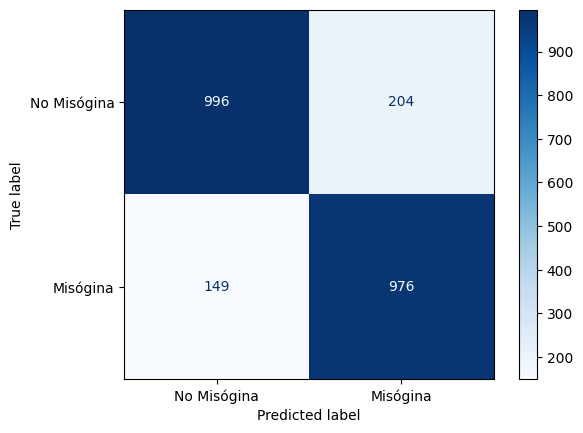

In [42]:
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Misógina", "Misógina"])
disp.plot(cmap='Blues')

In [41]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred, target_names=["No Misógina", "Misógina"]))


              precision    recall  f1-score   support

 No Misógina       0.87      0.83      0.85      1200
    Misógina       0.83      0.87      0.85      1125

    accuracy                           0.85      2325
   macro avg       0.85      0.85      0.85      2325
weighted avg       0.85      0.85      0.85      2325



## Modelo roberta-base-bne

In [46]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer

# Cargar tus splits
train_df, val_df, test_df = train, val, test  # Usa los DataFrames creados antes

for df in [train_df, val_df, test_df]:
    df['lyrics'] = df['lyrics'].astype(str)
    df['label'] = df['label'].astype(int)

# Convertir a datasets de Hugging Face
train_ds = Dataset.from_pandas(train_df[['lyrics', 'label']].rename(columns={'lyrics': 'text'}).reset_index(drop=True))
val_ds = Dataset.from_pandas(val_df[['lyrics', 'label']].rename(columns={'lyrics': 'text'}).reset_index(drop=True))
test_ds = Dataset.from_pandas(test_df[['lyrics', 'label']].rename(columns={'lyrics': 'text'}).reset_index(drop=True))

# Tokenizer y modelo
model_name = "PlanTL-GOB-ES/roberta-base-bne"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

tokenizer_config.json:   0%|          | 0.00/1.39k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/851k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/509k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.21M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/957 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/613 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at PlanTL-GOB-ES/roberta-base-bne and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [47]:
# Tokenizar
def tokenize(batch):
    return tokenizer(batch["text"], padding="max_length", truncation=True, max_length=512)

train_ds = train_ds.map(tokenize, batched=True)
val_ds = val_ds.map(tokenize, batched=True)
test_ds = test_ds.map(tokenize, batched=True)

Map:   0%|          | 0/8135 [00:00<?, ? examples/s]

Map:   0%|          | 0/1162 [00:00<?, ? examples/s]

Map:   0%|          | 0/2325 [00:00<?, ? examples/s]

In [48]:
# Métricas
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds)
    }

In [49]:
# Entrenamiento
training_args = TrainingArguments(
    output_dir="./results/roberta",
    eval_strategy = "epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=4,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    logging_dir="./logs",
    report_to="none"
)

In [50]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

<ipython-input-50-6c948078bb4e>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [51]:
# Entrenar
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.442522,0.790878,0.750769
2,0.387900,0.372800,0.847676,0.845144
3,0.387900,0.425613,0.857143,0.852313
4,0.110400,0.548140,0.858003,0.855136


TrainOutput(global_step=1020, training_loss=0.24467136266769146, metrics={'train_runtime': 2957.8812, 'train_samples_per_second': 11.001, 'train_steps_per_second': 0.345, 'total_flos': 8561633741414400.0, 'train_loss': 0.24467136266769146, 'epoch': 4.0})

In [52]:
# Evaluar en test
test_metrics = trainer.evaluate(test_ds)
print(test_metrics)

{'eval_loss': 0.579836905002594, 'eval_accuracy': 0.8326881720430107, 'eval_f1': 0.829010989010989, 'eval_runtime': 64.7123, 'eval_samples_per_second': 35.928, 'eval_steps_per_second': 1.128, 'epoch': 4.0}


In [53]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Obtener predicciones en el test set
preds_output = trainer.predict(test_ds)

# Convertir logits a clases predichas
y_pred = np.argmax(preds_output.predictions, axis=1)
y_true = preds_output.label_ids



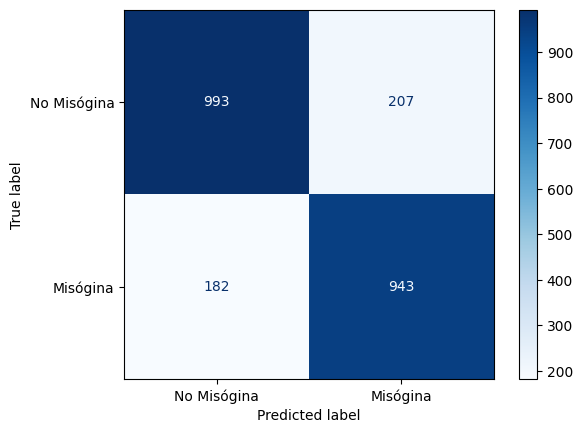

In [54]:
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Misógina", "Misógina"])
disp.plot(cmap='Blues')

In [55]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred, target_names=["No Misógina", "Misógina"]))

              precision    recall  f1-score   support

 No Misógina       0.85      0.83      0.84      1200
    Misógina       0.82      0.84      0.83      1125

    accuracy                           0.83      2325
   macro avg       0.83      0.83      0.83      2325
weighted avg       0.83      0.83      0.83      2325



## Modelo beto-sentiment-analysis

In [60]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer

# Cargar tus splits
train_df, val_df, test_df = train, val, test  # Usa los DataFrames creados antes

for df in [train_df, val_df, test_df]:
    df['lyrics'] = df['lyrics'].astype(str)
    df['label'] = df['label'].astype(int)

# Convertir a datasets de Hugging Face
train_ds = Dataset.from_pandas(train_df[['lyrics', 'label']].rename(columns={'lyrics': 'text'}).reset_index(drop=True))
val_ds = Dataset.from_pandas(val_df[['lyrics', 'label']].rename(columns={'lyrics': 'text'}).reset_index(drop=True))
test_ds = Dataset.from_pandas(test_df[['lyrics', 'label']].rename(columns={'lyrics': 'text'}).reset_index(drop=True))

# Tokenizer y modelo
model_name = "finiteautomata/beto-sentiment-analysis"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

In [61]:
# Tokenizar
def tokenize(batch):
    return tokenizer(batch["text"], padding="max_length", truncation=True, max_length=512)

train_ds = train_ds.map(tokenize, batched=True)
val_ds = val_ds.map(tokenize, batched=True)
test_ds = test_ds.map(tokenize, batched=True)

Map:   0%|          | 0/8135 [00:00<?, ? examples/s]

Map:   0%|          | 0/1162 [00:00<?, ? examples/s]

Map:   0%|          | 0/2325 [00:00<?, ? examples/s]

In [62]:
# Métricas
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds)
    }

In [64]:
# Entrenamiento
training_args = TrainingArguments(
    output_dir="./results/beto",
    eval_strategy = "epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=4,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    logging_dir="./logs",
    report_to="none"
)

In [65]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

<ipython-input-65-6c948078bb4e>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [66]:
# Entrenar
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.442547,0.790878,0.751788
2,0.427600,0.389532,0.839071,0.833482
3,0.427600,0.421043,0.851119,0.850991
4,0.174000,0.528315,0.850258,0.848168


TrainOutput(global_step=1020, training_loss=0.2967963976018569, metrics={'train_runtime': 3145.2534, 'train_samples_per_second': 10.346, 'train_steps_per_second': 0.324, 'total_flos': 8561710612869120.0, 'train_loss': 0.2967963976018569, 'epoch': 4.0})

In [67]:
# Evaluar en test
test_metrics = trainer.evaluate(test_ds)
print(test_metrics)

{'eval_loss': 0.4258871376514435, 'eval_accuracy': 0.8460215053763441, 'eval_f1': 0.8480475382003395, 'eval_runtime': 70.1822, 'eval_samples_per_second': 33.128, 'eval_steps_per_second': 1.04, 'epoch': 4.0}


In [68]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Obtener predicciones en el test set
preds_output = trainer.predict(test_ds)

# Convertir logits a clases predichas
y_pred = np.argmax(preds_output.predictions, axis=1)
y_true = preds_output.label_ids

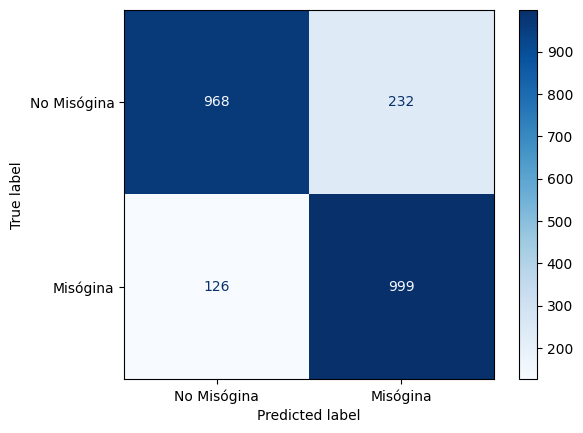

In [69]:
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Misógina", "Misógina"])
disp.plot(cmap='Blues')

In [70]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred, target_names=["No Misógina", "Misógina"]))

              precision    recall  f1-score   support

 No Misógina       0.88      0.81      0.84      1200
    Misógina       0.81      0.89      0.85      1125

    accuracy                           0.85      2325
   macro avg       0.85      0.85      0.85      2325
weighted avg       0.85      0.85      0.85      2325



# Upload model to huggingfaces


In [36]:
!pip install -U transformers huggingface_hub

In [ ]:
from huggingface_hub import login

# Inserta tu token personal de Hugging Face (lo puedes generar en huggingface.co/settings/tokens)

In [72]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

# Nombre del modelo
model_name = "beto-sentiment-analysis"

# Guarda localmente
trainer.save_model(model_name)
tokenizer.save_pretrained(model_name)

('beto-sentiment-analysis/tokenizer_config.json',
 'beto-sentiment-analysis/special_tokens_map.json',
 'beto-sentiment-analysis/vocab.txt',
 'beto-sentiment-analysis/added_tokens.json',
 'beto-sentiment-analysis/tokenizer.json')

In [73]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

# Recarga desde el directorio guardado
model = AutoModelForSequenceClassification.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Sube al Hub (esto crea un repo con ese nombre en tu cuenta)
model.push_to_hub(model_name)
tokenizer.push_to_hub(model_name)

model.safetensors:   0%|          | 0.00/439M [00:00<?, ?B/s]

README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/no0ne-97/beto-sentiment-analysis/commit/cfc24f546a9bd9f2a3d75f507283d44674b1cf34', commit_message='Upload tokenizer', commit_description='', oid='cfc24f546a9bd9f2a3d75f507283d44674b1cf34', pr_url=None, repo_url=RepoUrl('https://huggingface.co/no0ne-97/beto-sentiment-analysis', endpoint='https://huggingface.co', repo_type='model', repo_id='no0ne-97/beto-sentiment-analysis'), pr_revision=None, pr_num=None)